# Unsupervised image denoising

## Import libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, Lambda, Normalize, Grayscale
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm.notebook import tqdm
import os

## Load data

In [2]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/Machine_Learning/'
filename_data   = 'assignment_08_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))


original_train = data['original_train'] 
noise_train    = data['noise_train']

original_test = data['original_test'] 
noise_test    = data['noise_test']

print('*************************************************')
print('size of noise_train    : ', noise_train.shape)
print('*************************************************')
print('size of noise_test    : ', noise_test.shape)
print('*************************************************')
print('number of training image :', noise_train.shape[0])
print('height of training image :', noise_train.shape[1])
print('width of training image  :', noise_train.shape[2])
print('*************************************************')
print('number of testing image :', noise_test.shape[0])
print('height of testing image :', noise_test.shape[1])
print('width of testing image  :', noise_test.shape[2])
print('*************************************************')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
*************************************************
size of noise_train    :  (2000, 64, 64)
*************************************************
size of noise_test    :  (900, 64, 64)
*************************************************
number of training image : 2000
height of training image : 64
width of training image  : 64
*************************************************
number of testing image : 900
height of testing image : 64
width of testing image  : 64
*************************************************


## Hyper parameters

In [3]:
device        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==================================================
# determine optimal hyper-parameters to obtain best testing performance
number_epoch    = 300
size_minibatch  = 32
learning_rate   = 0.1
momentum        = 0.9
weight_decay    = 0.001
weight_total_variation = 0.005
# ==================================================

## Costumize dataloader for pytorch

In [4]:
class dataset (Dataset):
  def  __init__(self, original,noise):

    self.original = original
    self.noise    = noise
        
  def __getitem__(self, index):

    original    = self.original[index]
    noise       = self.noise[index]
    
    original   = torch.FloatTensor(original).unsqueeze(dim=0)
    noise      = torch.FloatTensor(noise).unsqueeze(dim=0)


    return (original , noise)
  
  def __len__(self):

     return self.original.shape[0]

In [5]:
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, Lambda, Normalize, Grayscale

class argu_dataset (Dataset):
  def  __init__(self, original, noise, transform):

    original = original.astype('float32')
    noise    = noise.astype('float32')
       
  def __getitem__(self, index):

    original    = self.original[index]
    noise       = self.noise[index]

    original = original.astype('float32')
    noise = noise.astype('float32')

    original   = self.transform(original)
    noise      = self.transform(noise)

    original   = torch.FloatTensor(original).unsqueeze(dim=0)
    noise      = torch.FloatTensor(noise).unsqueeze(dim=0)
    
    return (original , noise)
  
  def __len__(self):

     return self.original.shape[0]


## Construct datasets and dataloaders for training and testing

In [6]:
dataset_train = dataset(original_train, noise_train) 
dataset_test  = dataset(original_test, noise_test) 

dataloader_train = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True, num_workers=2)
dataloader_test  = DataLoader(dataset_test,  batch_size=size_minibatch, shuffle=False, drop_last=True, num_workers=2) 

## Shape of the data with data loader

In [7]:
(original_train, noise_train)   = dataset_train[0]
(original_test, noise_test)     = dataset_test[0]

print('************************************************************')
print('shape of the original image in the training dataset:', original_train.shape)
print('shape of the noisy image in the training dataset:', noise_train.shape)
print('************************************************************')
print('shape of the original image in the testing dataset:', original_test.shape)
print('shape of the noisy image in the testing dataset:', noise_test.shape)
print('************************************************************')

************************************************************
shape of the original image in the training dataset: torch.Size([1, 64, 64])
shape of the noisy image in the training dataset: torch.Size([1, 64, 64])
************************************************************
shape of the original image in the testing dataset: torch.Size([1, 64, 64])
shape of the noisy image in the testing dataset: torch.Size([1, 64, 64])
************************************************************


## Class for the neural network

In [8]:
class conv2DBatchNormRelu(nn.Module):
    def __init__(
            self,
            in_channels,
            n_filters,
            k_size,
            stride,
            padding,
            bias=True,
            dilation=1,
            with_bn=True,
    ):
        super(conv2DBatchNormRelu, self).__init__()

        conv_mod = nn.Conv2d(int(in_channels),
                             int(n_filters),
                             kernel_size=k_size,
                             padding=padding,
                             stride=stride,
                             bias=bias,
                             dilation=dilation, )

        if with_bn:
            self.cbr_unit = nn.Sequential(conv_mod,
                                          nn.BatchNorm2d(int(n_filters)),
                                          nn.ReLU(inplace=True))
        else:
            self.cbr_unit = nn.Sequential(conv_mod, nn.ReLU(inplace=True))

    def forward(self, inputs):
        outputs = self.cbr_unit(inputs)
        return outputs


class segnetDown2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown2, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetDown3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown3, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetUp2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp2, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class segnetUp3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp3, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        return outputs


class SegNet(nn.Module):
    def __init__(self, n_classes=1, in_channels=1, is_unpooling=True):
        super(SegNet, self).__init__()

        self.in_channels = in_channels
        self.is_unpooling = is_unpooling

        self.down1 = segnetDown2(self.in_channels, 64)
        self.down2 = segnetDown2(64, 128)
        self.down3 = segnetDown3(128, 256)
        self.down4 = segnetDown3(256, 512)
        self.down5 = segnetDown3(512, 512)

        self.up5 = segnetUp3(512, 512)
        self.up4 = segnetUp3(512, 256)
        self.up3 = segnetUp3(256, 128)
        self.up2 = segnetUp2(128, 64)
        self.up1 = segnetUp2(64, n_classes)

    def forward(self, inputs):

        down1, indices_1, unpool_shape1 = self.down1(inputs)
        down2, indices_2, unpool_shape2 = self.down2(down1)
        down3, indices_3, unpool_shape3 = self.down3(down2)
        down4, indices_4, unpool_shape4 = self.down4(down3)
        down5, indices_5, unpool_shape5 = self.down5(down4)

        up5 = self.up5(down5, indices_5, unpool_shape5)
        up4 = self.up4(up5, indices_4, unpool_shape4)
        up3 = self.up3(up4, indices_3, unpool_shape3)
        up2 = self.up2(up3, indices_2, unpool_shape2)
        up1 = self.up1(up2, indices_1, unpool_shape1)

        return up1

## Build the network

In [9]:
model = SegNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum , weight_decay=weight_decay)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Compute prediction (denoised image)

In [10]:
def compute_prediction(input, model):
    
    # ==================================================
    # fill up the blank
    prediction = model(input)
    # ==================================================
    
    return prediction

## Compute loss

In [11]:
def compute_fidelity(input, prediction):
    
    mse = nn.MSELoss()
    
    # ==================================================
    # fill up the blank
    loss_mse = mse(prediction, input)
    # ==================================================
    
    loss_mse_value = loss_mse.item() 
    
    return loss_mse, loss_mse_value

In [12]:
def compute_regularization(data, weight):
    
    bs_img, c_img, h_img, w_img = data.size()
   
    tv_height = torch.abs(data[:, :, 1:, :] - data[:, :, :- 1, :]).sum()
    tv_width  = torch.abs(data[:, :, :, 1:] - data[:, :, :, :-1]).sum()

    total_variation = (tv_height + tv_width) / (bs_img * c_img * h_img * w_img)
    
    # ==================================================
    # fill up the blank
    loss_regularization = weight * total_variation
    # ==================================================
    
    loss_regularization_value = loss_regularization.item()
     
    return loss_regularization, loss_regularization_value

In [13]:
def compute_loss(input, prediction, weight):

    (loss_fidelity, loss_fidelity_value) = compute_fidelity(input, prediction)
    (loss_regularization, loss_regularization_value) = compute_regularization(prediction, weight) 

    # ==================================================
    # fill up the blank
    loss = loss_fidelity + loss_regularization
    # ==================================================
    
    loss_value = loss.item()
    
    return loss, loss_value , loss_fidelity_value, loss_regularization_value

## Compute PSNR metric

In [14]:
def compute_PSNR(mse):

    if (mse==0.):
        PSNR=100    
    else :
        PSNR=10*log10(1.0 / mse)
        
    return PSNR

## Variable for the learning curves

In [15]:
loss_fidelity_mean_train       = np.zeros(number_epoch)
loss_fidelity_std_train        = np.zeros(number_epoch)
loss_regularization_mean_train = np.zeros(number_epoch)
loss_regularization_std_train  = np.zeros(number_epoch)
loss_mean_train                = np.zeros(number_epoch)
loss_std_train                 = np.zeros(number_epoch)
PSNR_mean_train                = np.zeros(number_epoch)
PSNR_std_train                 = np.zeros(number_epoch)

loss_fidelity_mean_test       = np.zeros(number_epoch)
loss_fidelity_std_test        = np.zeros(number_epoch)
loss_regularization_mean_test = np.zeros(number_epoch)
loss_regularization_std_test  = np.zeros(number_epoch)
loss_mean_test                = np.zeros(number_epoch)
loss_std_test                 = np.zeros(number_epoch)
PSNR_mean_test                = np.zeros(number_epoch)
PSNR_std_test                 = np.zeros(number_epoch)

## Train

In [16]:
def train(model, dataloader):

    loss_epoch          = []
    loss_fidelity_epoch = []
    loss_reg_epoch      = []
    psnr_epoch          = []

    model.train()

    for index_batch, (original, noise) in enumerate(dataloader):

        original = original.to(device)
        noise    = noise.to(device)
        
        prediction = compute_prediction(noise, model)
        (loss, loss_value, loss_fidelity_value, loss_regularization_value) = compute_loss(noise, prediction, weight_total_variation)
        
        # ==================================================
        # fill up the blank
        (mse, mse_value)    = compute_fidelity(original, prediction)
        psnr                = compute_PSNR(mse_value)
        # ==================================================

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        loss_fidelity_epoch.append(loss_fidelity_value)
        loss_reg_epoch.append(loss_regularization_value)
        psnr_epoch.append(psnr)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)
    
    loss_fidelity_mean_epoch     = np.mean(loss_fidelity_epoch)
    loss_fidelity_std_epoch      = np.std(loss_fidelity_epoch)
    
    loss_reg_mean_epoch     = np.mean(loss_reg_epoch)
    loss_reg_std_epoch      = np.std(loss_reg_epoch)

    psnr_mean_epoch = np.mean(psnr_epoch)
    psnr_std_epoch  = np.std(psnr_epoch)

    loss                       = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    loss_fidelity              = {'mean' : loss_fidelity_mean_epoch, 'std' : loss_fidelity_std_epoch}
    loss_regularization        = {'mean' : loss_reg_mean_epoch, 'std' : loss_reg_std_epoch}
    psnr                       = {'mean' : psnr_mean_epoch, 'std' : psnr_std_epoch}

    return (loss, loss_fidelity, loss_regularization, psnr)    


## Test

In [17]:
def test(model, dataloader):

    loss_epoch          = []
    loss_fidelity_epoch = []
    loss_reg_epoch      = []
    psnr_epoch          = []

    model.eval()

    for index_batch, (original, noise) in enumerate(dataloader):

        original = original.to(device)
        noise    = noise.to(device)

        prediction = compute_prediction(noise, model)
        (loss, loss_value, loss_fidelity_value, loss_regularization_value) = compute_loss(noise, prediction, weight_total_variation)
        
        # ==================================================
        # fill up the blank
        (mse, mse_value)    = compute_fidelity(original, prediction)
        psnr                = compute_PSNR(mse_value)
        # ==================================================

        loss_epoch.append(loss_value)
        loss_fidelity_epoch.append(loss_fidelity_value)
        loss_reg_epoch.append(loss_regularization_value)
        psnr_epoch.append(psnr)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)
    
    loss_fidelity_mean_epoch     = np.mean(loss_fidelity_epoch)
    loss_fidelity_std_epoch      = np.std(loss_fidelity_epoch)
    
    loss_reg_mean_epoch     = np.mean(loss_reg_epoch)
    loss_reg_std_epoch      = np.std(loss_reg_epoch)

    psnr_mean_epoch = np.mean(psnr_epoch)
    psnr_std_epoch  = np.std(psnr_epoch)

    loss                       = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    loss_fidelity              = {'mean' : loss_fidelity_mean_epoch, 'std' : loss_fidelity_std_epoch}
    loss_regularization        = {'mean' : loss_reg_mean_epoch, 'std' : loss_reg_std_epoch}
    psnr                       = {'mean' : psnr_mean_epoch, 'std' : psnr_std_epoch}

    return (loss, loss_fidelity, loss_regularization, psnr)    


## train and test

In [18]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, loss_fidelity_train, loss_reg_train, psnr_train) = train(model, dataloader_train)

    loss_mean_train[i] = loss_train['mean']
    loss_std_train[i]  = loss_train['std']
    
    loss_fidelity_mean_train[i] = loss_fidelity_train['mean']
    loss_fidelity_std_train[i]  = loss_fidelity_train['std']
    
    loss_regularization_mean_train[i] = loss_reg_train['mean']
    loss_regularization_std_train[i]  = loss_reg_train['std']

    PSNR_mean_train[i]  = psnr_train['mean']
    PSNR_std_train[i]   = psnr_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, loss_fidelity_test, loss_reg_test, psnr_test) = test(model, dataloader_test)

    loss_mean_test[i] = loss_test['mean']
    loss_std_test[i]  = loss_test['std']

    loss_fidelity_mean_test[i] = loss_fidelity_test['mean']
    loss_fidelity_std_test[i]  = loss_fidelity_test['std']
    
    loss_regularization_mean_test[i] = loss_reg_test['mean']
    loss_regularization_std_test[i]  = loss_reg_test['std']

    PSNR_mean_test[i]  = psnr_test['mean']
    PSNR_std_test[i]   = psnr_test['std']

    print(f"epooch : {i}, train loss : {loss_train['mean']}, train PSNR : {PSNR_mean_train[i]}, test loss : {loss_mean_test[i]}, test PSNR : {PSNR_mean_test[i]}")

  0%|          | 0/300 [00:00<?, ?it/s]

epooch : 0, train loss : 0.09736798253030546, train PSNR : 10.736589440051175, test loss : 0.07373890200895923, test PSNR : 11.548493696394766
epooch : 1, train loss : 0.04385224489435073, train PSNR : 14.373953481957345, test loss : 0.028749762901238034, test PSNR : 15.795384581479013
epooch : 2, train loss : 0.01674336477393104, train PSNR : 18.261109108276603, test loss : 0.014748584944754839, test PSNR : 18.60208206960658
epooch : 3, train loss : 0.013485101547332541, train PSNR : 18.894638839392965, test loss : 0.014449288569656866, test PSNR : 18.323752373366926
epooch : 4, train loss : 0.011918919987135356, train PSNR : 19.077166023604956, test loss : 0.010564571479335427, test PSNR : 19.3600958192173
epooch : 5, train loss : 0.009767486428421351, train PSNR : 19.68875355367083, test loss : 0.008632773899340205, test PSNR : 19.969109771750574
epooch : 6, train loss : 0.009079615014695352, train PSNR : 19.89948074265726, test loss : 0.009779463389090129, test PSNR : 19.5401550914

---

# functions for visualizing the results

---

## Plot functions

In [19]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * 3, nRow * 3))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [20]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * 3, nRow * 3))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [21]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [22]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [23]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [24]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [25]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [26]:
def function_result_01():

    print('[plot examples of the training images]')
    print('') 

    nRow = 5 
    nCol = 4
    index_data  = np.arange(0, nRow * nCol)
    image_train = dataset_train.noise[index_data]

    plot_data_grid(image_train, index_data, nRow, nCol)

In [27]:
def function_result_02():

    print('[plot examples of the training denoising results]')
    print('') 

    nRow = 5
    nCol = 4
    index_data          = np.arange(0, nRow * nCol)
    image_train         = torch.FloatTensor(dataset_train.noise[index_data]).unsqueeze(dim=1).to(device)
    prediction_train    = compute_prediction(image_train, model)
    
    plot_data_tensor_grid(prediction_train, index_data, nRow, nCol)

In [28]:
def function_result_03():

    print('[plot examples of the testing images]')
    print('') 
    
    nRow = 5
    nCol = 4
    index_data = np.arange(0, nRow * nCol)
    image_test = dataset_test.noise[index_data]

    plot_data_grid(image_test, index_data, nRow, nCol)

In [29]:
def function_result_04():

    print('[plot examples of the testing denoising results]')
    print('') 

    nRow = 5
    nCol = 4
    index_data      = np.arange(0, nRow * nCol)
    image_test      = torch.FloatTensor(dataset_test.noise[index_data]).unsqueeze(dim=1).to(device)
    prediction_test = compute_prediction(image_test, model)

    plot_data_tensor_grid(prediction_test, index_data, nRow, nCol)

In [30]:
def function_result_05():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'training loss')

In [31]:
def function_result_06():

    print('[plot the training fidelity loss]')
    print('') 

    plot_curve_error(loss_fidelity_mean_train, loss_fidelity_std_train, 'epoch', 'loss', 'training loss (fidelity)')

In [32]:
def function_result_07():

    print('[plot the training regularization loss]')
    print('') 

    plot_curve_error(loss_regularization_mean_train, loss_regularization_std_train, 'epoch', 'loss', 'training loss (regularization)')

In [33]:
def function_result_08():

    print('[plot the training PSNR]')
    print('') 
    
    plot_curve_error(PSNR_mean_train, PSNR_std_train, 'epoch', 'PSNR', 'training PSNR')

In [34]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'testing loss')

In [35]:
def function_result_10():
    
    print('[plot the testing fidelity loss]')
    print('') 
    
    plot_curve_error(loss_fidelity_mean_test, loss_fidelity_std_test, 'epoch', 'loss', 'testing loss (fidelity)')

In [36]:
def function_result_11():
    
    print('[plot the testing regularization loss]')
    print('') 
    
    plot_curve_error(loss_regularization_mean_test, loss_regularization_std_test, 'epoch', 'loss', 'testing loss (regularization)')

In [37]:
def function_result_12():
    
    print('[plot the testing PSNR]') 
    print('') 
    
    plot_curve_error(PSNR_mean_test, PSNR_std_test, 'epoch', 'PSNR', 'testing PSNR')

In [38]:
def function_result_13():
    
    print('[print the training loss (mean) at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [39]:
def function_result_14():
    
    print('[print the training PSNR (mean) at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(PSNR_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [40]:
def function_result_15():
    
    print('[print the testing loss (mean) at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [41]:
def function_result_16():
    
    print('[print the testing PSNR (mean) at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(PSNR_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [42]:
def function_result_17():
    
    print('[print the best training PSNR (mean) within the last 10 epochs]')
    print('') 

    value = get_max_last_range(PSNR_mean_train, -10)
    print('best training PSNR = %12.10f' % (value))

In [43]:
def function_result_18():
    
    print('[print the best testing PSNR (mean) within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(PSNR_mean_test, -10)
    print('best testing PSNR = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training images]



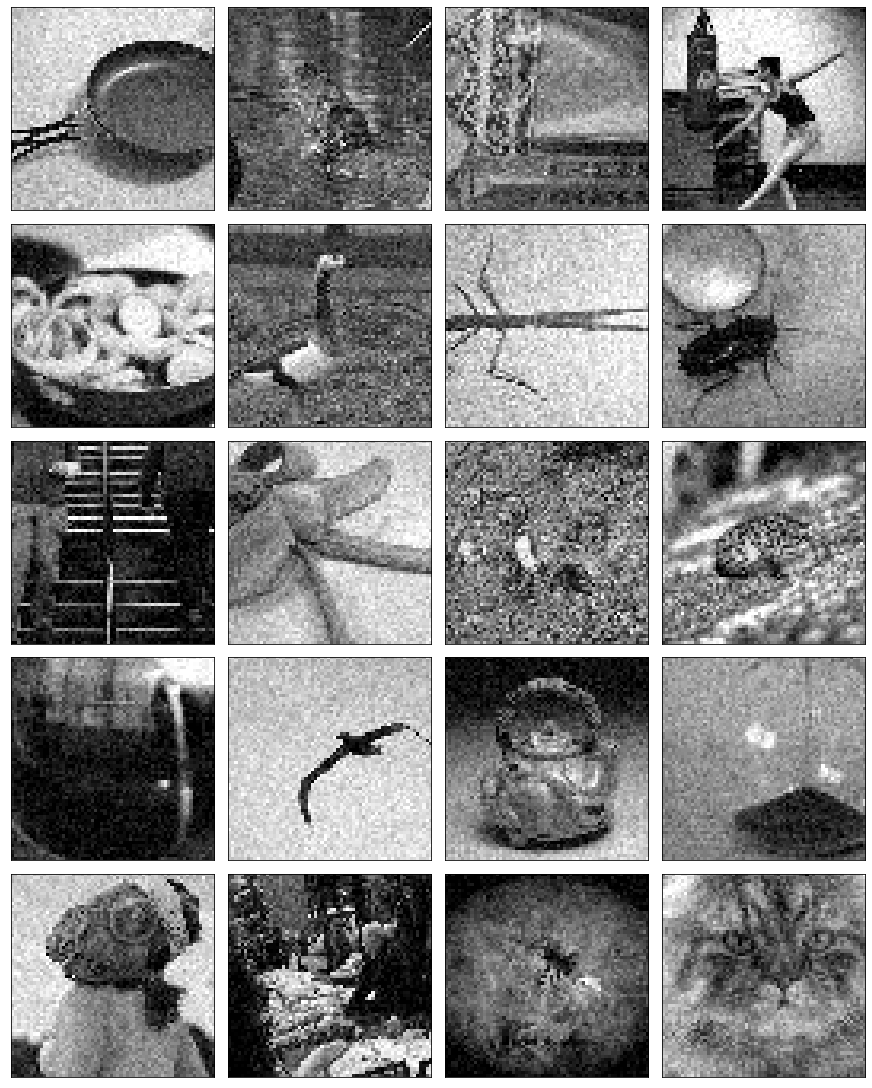


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training denoising results]



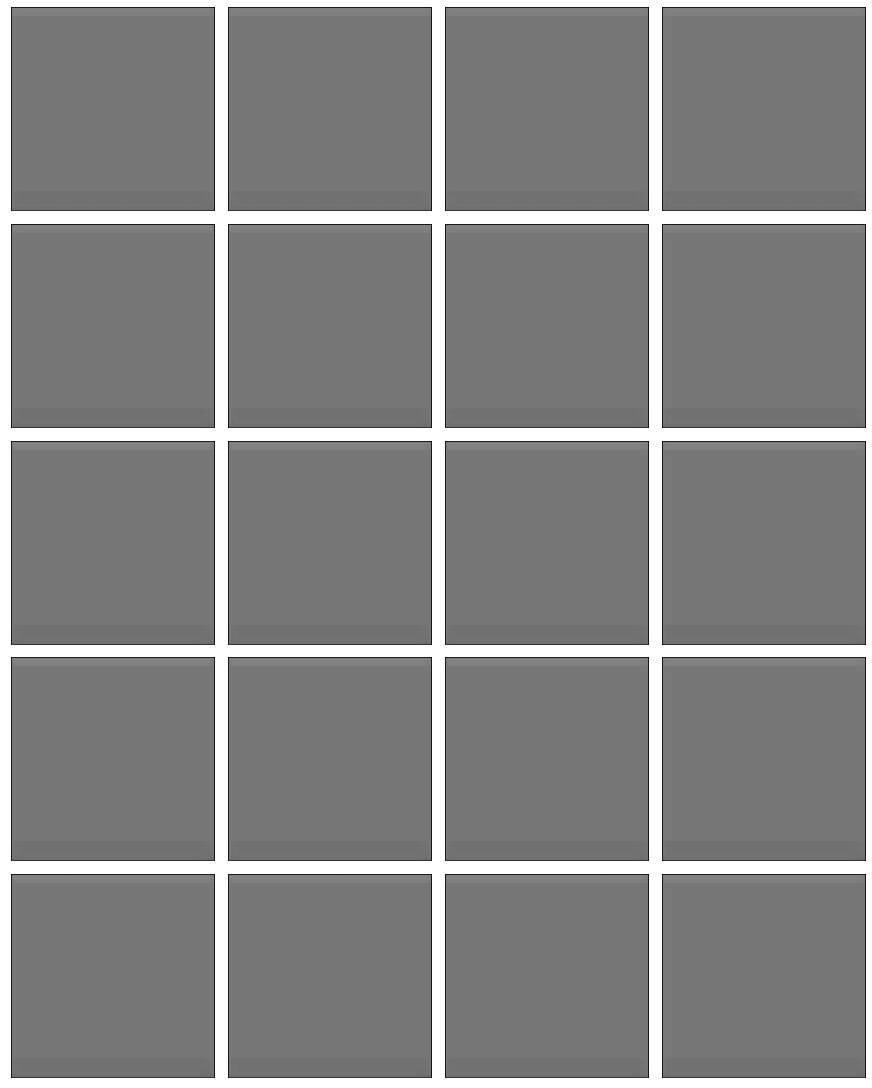


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the testing images]



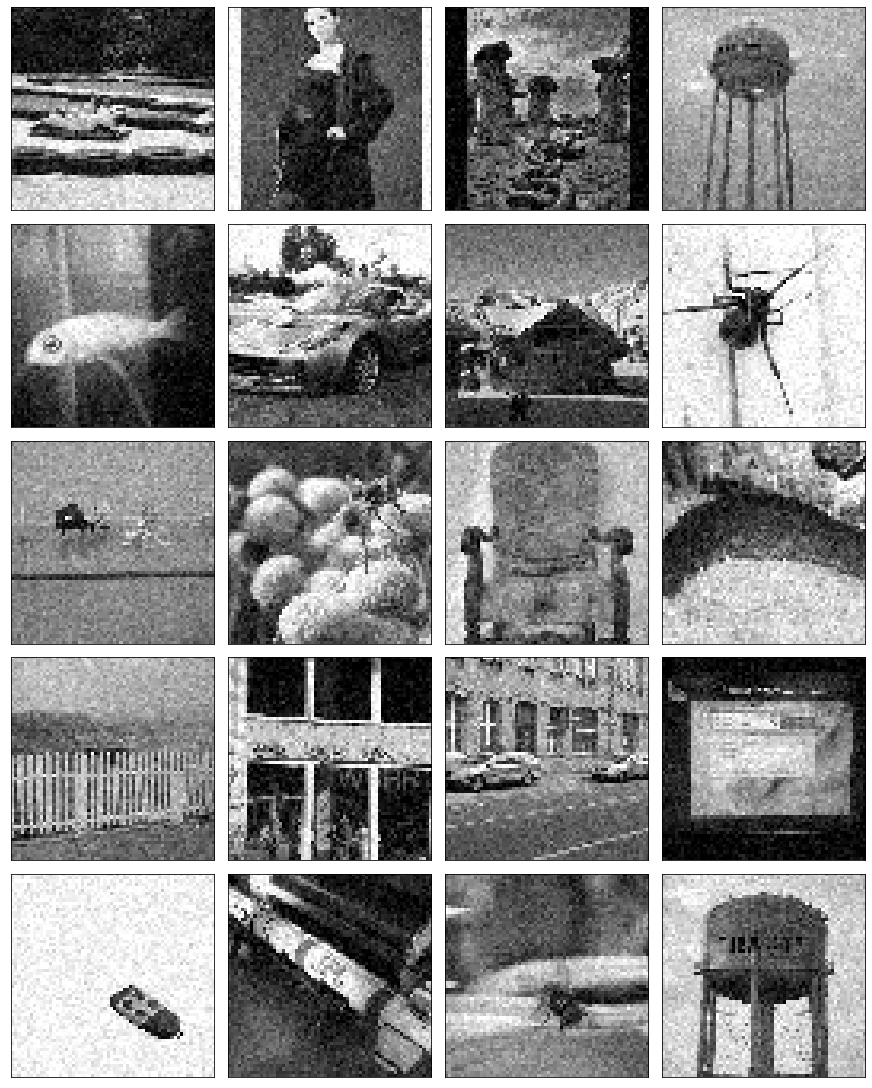


################################################################################
#
# RESULT # 04
#
################################################################################

[plot examples of the testing denoising results]



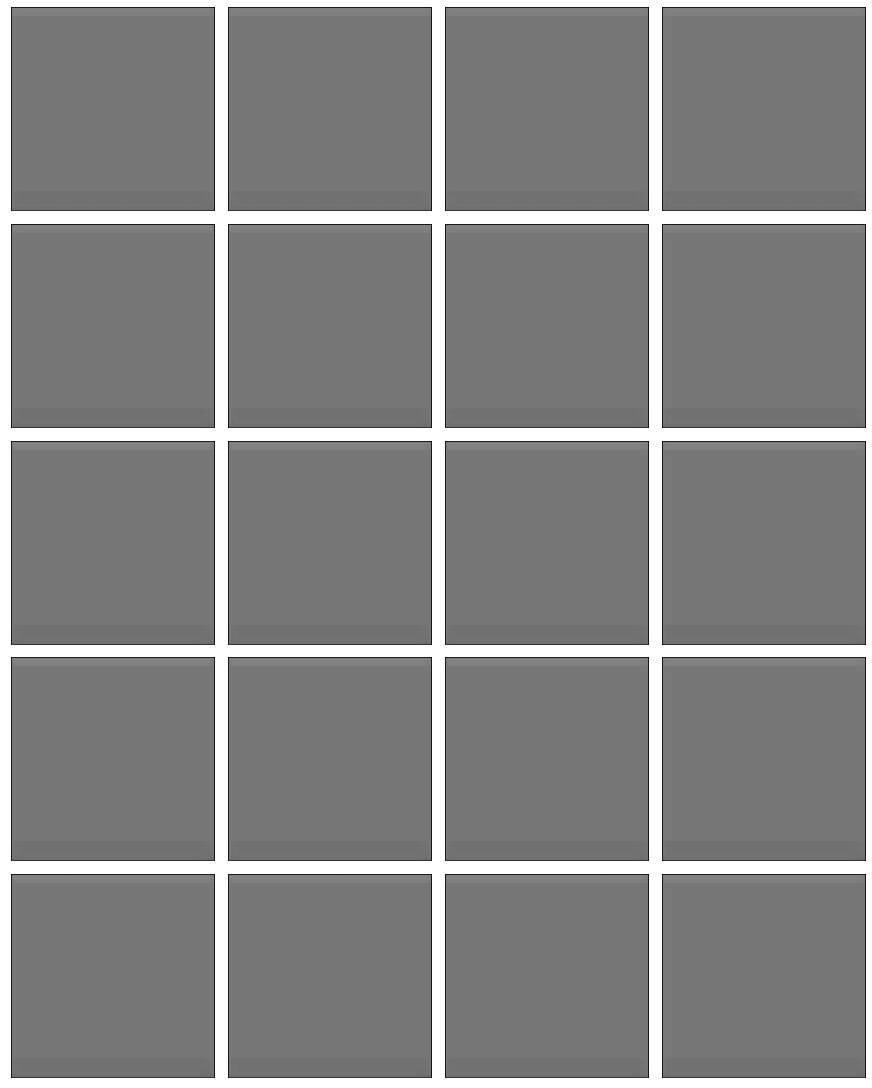


################################################################################
#
# RESULT # 05
#
################################################################################

[plot the training loss]



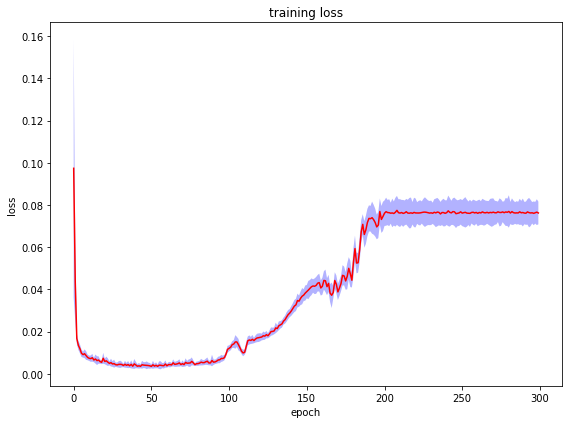


################################################################################
#
# RESULT # 06
#
################################################################################

[plot the training fidelity loss]



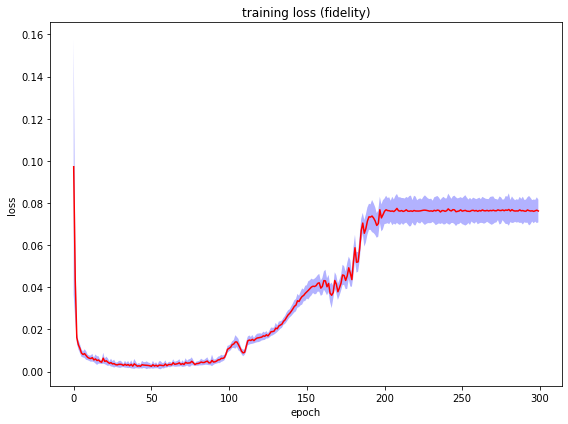


################################################################################
#
# RESULT # 07
#
################################################################################

[plot the training regularization loss]



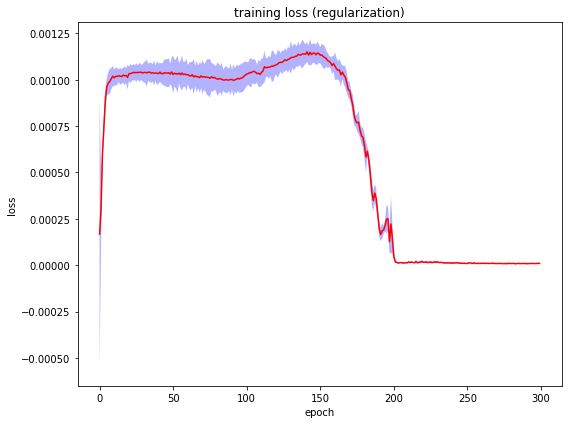


################################################################################
#
# RESULT # 08
#
################################################################################

[plot the training PSNR]



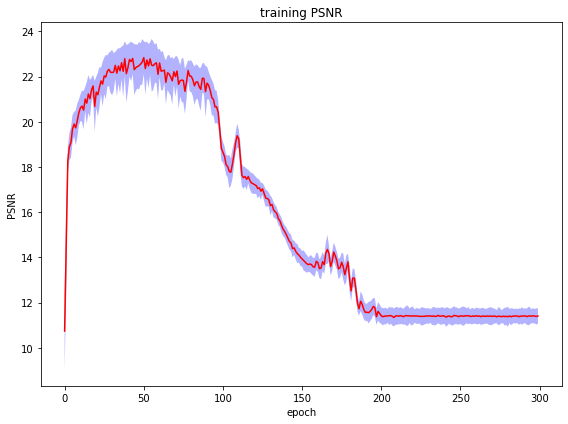


################################################################################
#
# RESULT # 09
#
################################################################################

[plot the testing loss]



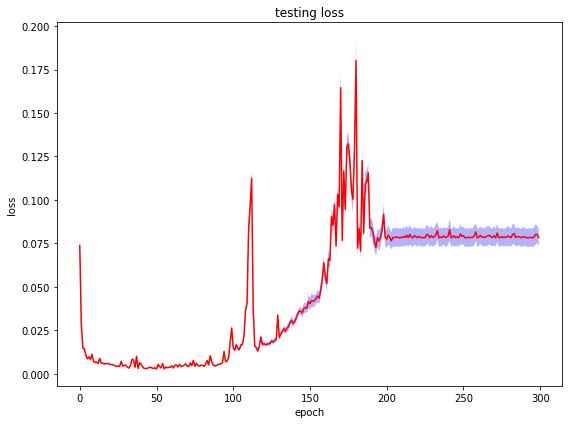


################################################################################
#
# RESULT # 10
#
################################################################################

[plot the testing fidelity loss]



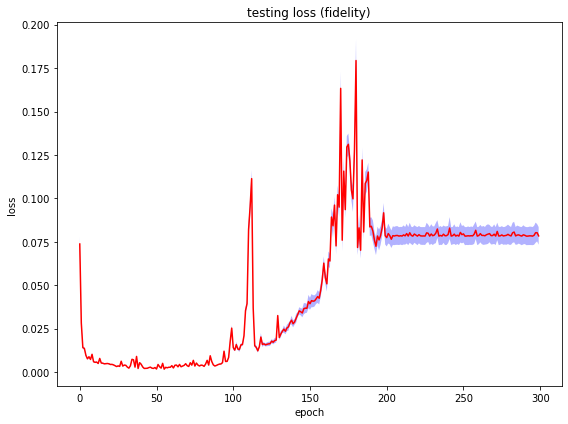


################################################################################
#
# RESULT # 11
#
################################################################################

[plot the testing regularization loss]



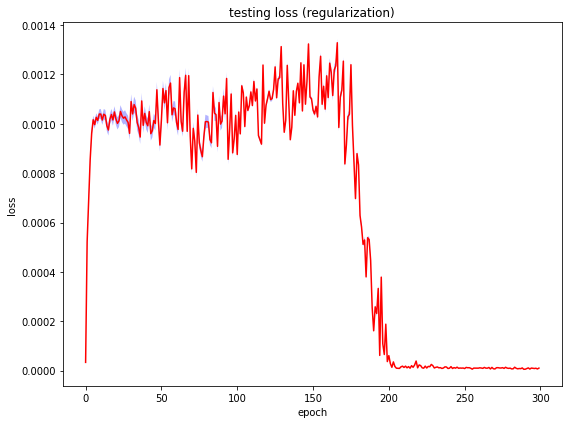


################################################################################
#
# RESULT # 12
#
################################################################################

[plot the testing PSNR]



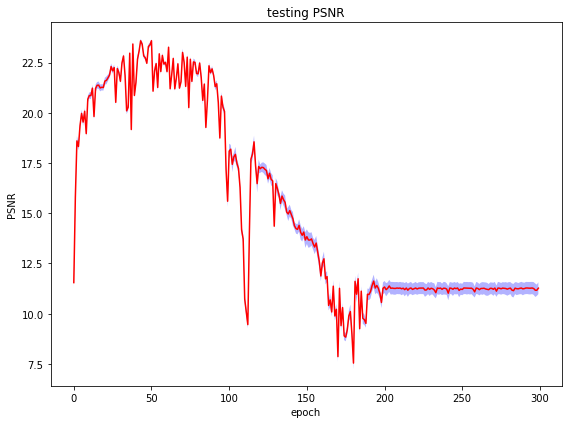


################################################################################
#
# RESULT # 13
#
################################################################################

[print the training loss (mean) at the last 10 epochs]

index =  0, value = 0.0761595233
index =  1, value = 0.0760980853
index =  2, value = 0.0767018189
index =  3, value = 0.0763609502
index =  4, value = 0.0762070100
index =  5, value = 0.0762987307
index =  6, value = 0.0760299488
index =  7, value = 0.0763134353
index =  8, value = 0.0765962865
index =  9, value = 0.0762014569

################################################################################
#
# RESULT # 14
#
################################################################################

[print the training PSNR (mean) at the last 10 epochs]

index =  0, value = 11.4063460096
index =  1, value = 11.4107909820
index =  2, value = 11.3769988141
index =  3, value = 11.4024006138
index =  4, value = 11.4078080244
index =  5, value = 11.3

In [44]:
number_result = 18

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)